# Credit Risk — PD Modeling (J.P. Morgan prototype)
- Notebook author: Jaime (Data Scientist)
- Dataset: Task 3 and 4_Loan_Data.csv
- Reference: CREDIT RISK ANALYSIS TASK.docx.

In [1]:
# ## 0. Setup and imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, precision_recall_curve)
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# xgboost
from xgboost import XGBClassifier



## 1. Load data and quick inspection


In [2]:
# Adjust path if needed
DATA_PATH = 'Task 3 and 4_Loan_Data.csv'
df = pd.read_csv(DATA_PATH)

print("Rows, columns:", df.shape)
df.head()

Rows, columns: (10000, 8)


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [3]:
# Quick datatype/missingness summary
display(df.info())
display(df.describe().T)
display(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


None

,count,mean,std,min,25%,50%,75%,max
customer_id,10000.0,4.974577e+06,2.293890e+06,1.000324e+06,2.977661e+06,4.989502e+06,6.967210e+06,8.999789e+06
credit_lines_outstanding,10000.0,1.461200e+00,1.743846e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00
loan_amt_outstanding,10000.0,4.159677e+03,1.421399e+03,4.678397e+01,3.154235e+03,4.052377e+03,5.052898e+03,1.075068e+04
total_debt_outstanding,10000.0,8.718917e+03,6.627165e+03,3.165273e+01,4.199836e+03,6.732407e+03,1.127226e+04,4.368878e+04
income,10000.0,7.003990e+04,2.007221e+04,1.000000e+03,5.653987e+04,7.008583e+04,8.342917e+04,1.484122e+05
years_employed,10000.0,4.552800e+00,1.566862e+00,0.000000e+00,3.000000e+00,5.000000e+00,6.000000e+00,1.000000e+01
fico_score,10000.0,6.375577e+02,6.065791e+01,4.080000e+02,5.970000e+02,6.380000e+02,6.790000e+02,8.500000e+02
default,10000.0,1.851000e-01,3.883981e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

## 2. ETL / Data cleaning
- Drop `customer_id`.
- Impute numeric missing values with median (if any).
- Basic sanity checks: non-negative income, reasonable FICO (300-850).


In [4]:
# Drop customer id if present
if 'customer_id' in df.columns:
    df = df.drop(columns=['customer_id'])

# Sanity checks
print("FICO min/max:", df['fico_score'].min(), df['fico_score'].max())
print("Income min:", df['income'].min())

# If any negative or zero incomes, flag or impute
df = df[df['income'] > 0].copy()  # keep rows with positive income


FICO min/max: 408 850
Income min: 1000.0


## 3. Feature engineering
Create:
- debt_to_income = total_debt_outstanding / income
- loan_to_income = loan_amt_outstanding / income
- fico_bucket (categorical)


In [5]:
df['debt_to_income'] = df['total_debt_outstanding'] / df['income']
df['loan_to_income'] = df['loan_amt_outstanding'] / df['income']

# FICO bucket
def fico_bucket(f):
    if f < 580:
        return 'deep_subprime'
    elif f < 640:
        return 'subprime'
    elif f < 700:
        return 'near_prime'
    else:
        return 'prime'
df['fico_bucket'] = df['fico_score'].apply(fico_bucket)

# Quick check
df[['fico_score','fico_bucket','debt_to_income','loan_to_income']].head()


,fico_score,fico_bucket,debt_to_income,loan_to_income
0,605,subprime,0.050173,0.066909
1,572,deep_subprime,0.308789,0.073510
2,602,subprime,0.030787,0.051058
3,612,subprime,0.033645,0.064105
4,631,subprime,0.075435,0.057395


## 4. Prepare features and split data
- Use numeric features: credit_lines_outstanding, loan_amt_outstanding, total_debt_outstanding,
  income, years_employed, fico_score, debt_to_income, loan_to_income
- Encode fico_bucket if needed (one-hot) — I'll use numeric features only for tree models (they don't need scaling).
- Stratified train/test split on `default`.

In [6]:
features = ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding',
            'income', 'years_employed', 'fico_score', 'debt_to_income', 'loan_to_income']

X = df[features].copy()
y = df['default'].copy()

# train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Default rate - train:", y_train.mean(), "test:", y_test.mean())


Train shape: (7000, 8) Test shape: (3000, 8)
Default rate - train: 0.18514285714285714 test: 0.185


## 5. Baseline model: Logistic Regression
- Pipelines with imputation and scaling.
- Evaluate basic metrics.

In [7]:
from sklearn.pipeline import make_pipeline

num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

pipe_lr = Pipeline(steps=[
    ('imputer', num_imputer),
    ('scaler', scaler),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:,1]

def summarize_model(name, y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba)
    return {'model': name, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': auc}

results = []
results.append(summarize_model('LogisticRegression', y_test, y_pred_lr, y_proba_lr))
results


[{'model': 'LogisticRegression',
  'accuracy': 0.9963333333333333,
  'precision': 0.980565371024735,
  'recall': 1.0,
  'f1': 0.9901873327386262,
  'roc_auc': 0.9999911568009727}]

## 6. Random Forest
Train a RandomForestClassifier (with a basic hyperparameter grid) and evaluate.

In [8]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)

# Fit on numeric data directly (trees handle scales)
rf.fit(X_train.fillna(X_train.median()), y_train)
y_pred_rf = rf.predict(X_test.fillna(X_train.median()))
y_proba_rf = rf.predict_proba(X_test.fillna(X_train.median()))[:,1]

results.append(summarize_model('RandomForest', y_test, y_pred_rf, y_proba_rf))
results[-1]


{'model': 'RandomForest',
 'accuracy': 0.993,
 'precision': 0.9872262773722628,
 'recall': 0.9747747747747748,
 'f1': 0.9809610154125114,
 'roc_auc': 0.9997265977634076}

## 7. XGBoost
Train XGBoost with a simple set of hyperparameters. Use `scale_pos_weight` if imbalance is present.

In [9]:
# Determine scale_pos_weight = N_negative / N_positive
neg = (y_train==0).sum()
pos = (y_train==1).sum()
scale_pos_weight = neg / (pos+1e-9)
scale_pos_weight


4.401234567897839

In [10]:
xgb = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.1,
                    use_label_encoder=False, eval_metric='logloss',
                    scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1)

xgb.fit(X_train.fillna(X_train.median()), y_train)
y_pred_xgb = xgb.predict(X_test.fillna(X_train.median()))
y_proba_xgb = xgb.predict_proba(X_test.fillna(X_train.median()))[:,1]

results.append(summarize_model('XGBoost', y_test, y_pred_xgb, y_proba_xgb))
results[-1]


{'model': 'XGBoost',
 'accuracy': 0.9963333333333333,
 'precision': 0.9892086330935251,
 'recall': 0.990990990990991,
 'f1': 0.9900990099009901,
 'roc_auc': 0.9999705226699092}

## 8. Results comparison table
Show a compact DataFrame with metrics for each model.

In [11]:
res_df = pd.DataFrame(results).set_index('model')
display(res_df)

,accuracy,precision,recall,f1,roc_auc
model,,,,,
LogisticRegression,0.996333,0.980565,1.000000,0.990187,0.999991
RandomForest,0.993000,0.987226,0.974775,0.980961,0.999727
XGBoost,0.996333,0.989209,0.990991,0.990099,0.999971


## 9. Confusion matrices and ROC curves

In [12]:
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

# Confusion matrices
for name, y_pred in [('LogisticRegression', y_pred_lr), ('RandomForest', y_pred_rf), ('XGBoost', y_pred_xgb)]:
    print(f"Confusion matrix for {name}")
    display(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, {'LogisticRegression': y_pred_lr, 'RandomForest': y_pred_rf, 'XGBoost': y_pred_xgb}[name], zero_division=0))


Confusion matrix for LogisticRegression


array([[2434,   11],
       [   0,  555]], dtype=int64)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2445
           1       0.98      1.00      0.99       555

    accuracy                           1.00      3000
   macro avg       0.99      1.00      0.99      3000
weighted avg       1.00      1.00      1.00      3000

Confusion matrix for RandomForest


array([[2438,    7],
       [  14,  541]], dtype=int64)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2445
           1       0.99      0.97      0.98       555

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion matrix for XGBoost


array([[2439,    6],
       [   5,  550]], dtype=int64)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2445
           1       0.99      0.99      0.99       555

    accuracy                           1.00      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       1.00      1.00      1.00      3000



<Figure size 640x480 with 0 Axes>

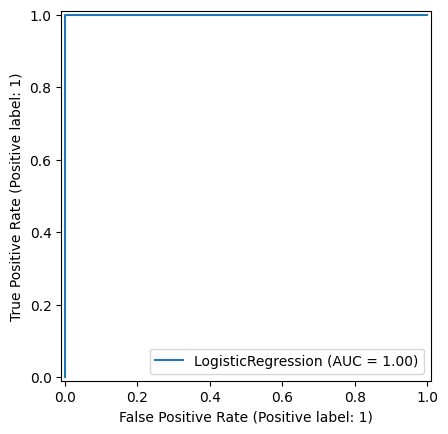

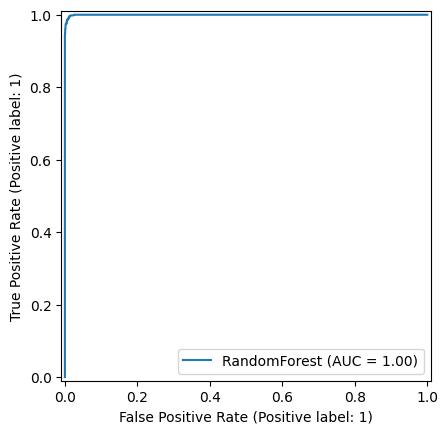

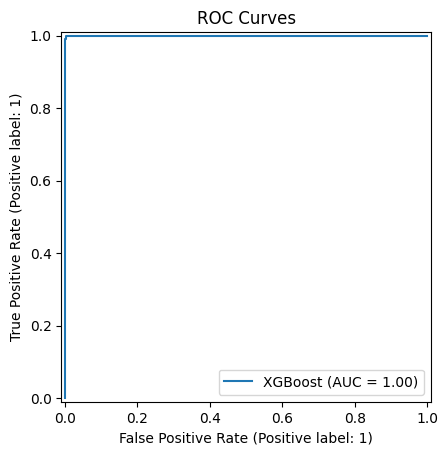

In [13]:
# ROC
plt.figure()
RocCurveDisplay.from_predictions(y_test, y_proba_lr, name='LogisticRegression')
RocCurveDisplay.from_predictions(y_test, y_proba_rf, name='RandomForest')
RocCurveDisplay.from_predictions(y_test, y_proba_xgb, name='XGBoost')
plt.title("ROC Curves")
plt.show()


## 10. Expected loss function & example inference
- Define function: `expected_loss(loan_amount, pd_pred, recovery_rate=0.10)`
- Also provide end-to-end inference on the test set.

In [14]:
def expected_loss(loan_amount, pd_pred, recovery_rate=0.10):
    """
    Expected loss = PD * (1 - recovery_rate) * exposure
    - loan_amount: exposure (float)
    - pd_pred: probability of default (0..1)
    - recovery_rate: e.g., 0.10 for 10%
    """
    return pd_pred * (1.0 - recovery_rate) * loan_amount

# Example: compute expected loss on test set using chosen model (XGBoost here)
test_df = X_test.copy()
test_df['pd_xgb'] = y_proba_xgb
test_df['expected_loss_xgb'] = expected_loss(test_df['loan_amt_outstanding'], test_df['pd_xgb'], recovery_rate=0.10)

# show top 10 loans by expected loss
display(test_df.sort_values('expected_loss_xgb', ascending=False).head(10))


,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,debt_to_income,loan_to_income,pd_xgb,expected_loss_xgb
9944,4,8989.178801,30103.66256,124197.63370,2,641,0.242385,0.072378,0.999994,8090.215164
5460,5,8841.923630,32644.92158,115203.15190,2,541,0.283368,0.076751,0.999999,7957.719462
6364,4,8802.265206,26544.26350,108128.84130,2,534,0.245487,0.081405,0.999997,7922.018539
346,5,8638.366979,32789.35274,111631.44970,4,627,0.293729,0.077383,0.999994,7774.486310
7475,5,8427.592750,38215.41353,114303.69530,4,657,0.334332,0.073730,0.999992,7584.768977
2133,5,8276.572480,43688.78410,121048.35320,2,701,0.360920,0.068374,0.999956,7448.585495
5201,5,8055.214307,29424.29041,103156.28370,3,578,0.285240,0.078087,0.999999,7249.684042
7224,5,8042.192655,31775.12918,102824.67930,2,612,0.309022,0.078213,0.999997,7237.954024
7295,4,8133.432746,18333.75749,92937.53071,5,668,0.197270,0.087515,0.986992,7224.868692
7089,5,7989.706883,33434.40397,112065.01990,1,674,0.298348,0.071295,0.999994,7190.691239


## 11. Model saving and inference function
Save the best model pipeline (here we save XGBoost). Provide `predict_pd` function.

In [15]:
# Save the xgboost model and optionally the preprocessing median values
joblib.dump(xgb, 'xgb_pd_model.joblib')
# Save median imputer dict for later imputing
median_vals = X_train.median()
joblib.dump(median_vals, 'median_vals.joblib')

# Inference function
def predict_pd_and_expected_loss(model, median_vals, row_dict, recovery_rate=0.10):
    """
    model: trained classifier with predict_proba
    median_vals: Series of median values to impute missing features
    row_dict: dict with required features keys
    """
    x = pd.DataFrame([row_dict])
    # compute engineered features if missing
    if 'debt_to_income' not in x.columns:
        x['debt_to_income'] = x['total_debt_outstanding'] / x['income']
    if 'loan_to_income' not in x.columns:
        x['loan_to_income'] = x['loan_amt_outstanding'] / x['income']
    # impute
    x = x[median_vals.index].fillna(median_vals)
    pd_pred = model.predict_proba(x)[:,1][0]
    exp_loss = expected_loss(x['loan_amt_outstanding'].iloc[0], pd_pred, recovery_rate)
    return pd_pred, exp_loss

# Example single loan
example_row = X_test.iloc[0].to_dict()
pd_pred, exp_loss = predict_pd_and_expected_loss(xgb, median_vals, example_row, recovery_rate=0.10)
print("PD:", pd_pred, "Expected loss:", exp_loss)


PD: 2.4962662e-06 Expected loss: 0.007081400422229445


## 12. Next steps and production considerations
- Calibrate PD outputs (Platt scaling or isotonic) if you plan to use PDs for provisioning.
- Monitor drift & performance (backtest PD vs realized defaults).
- Consider cost-sensitive thresholding — choose threshold by maximizing expected utility or minimizing expected loss.
- Add explainability (SHAP) for regulatory transparency.
- Add bootstrap / uncertainty quantification for PDs.